
... ***CURRENTLY UNDER DEVELOPMENT*** ...


In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op

# pip
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..', '..'))

# teslakit 
from teslakit.database import Database
from teslakit.estela import spatial_gradient, Predictor
from teslakit.util.time_operations import xds_common_dates_daily

from teslakit.plotting.estela import Plot_ESTELA
from teslakit.plotting.wts import Plot_Probs_WT_WT
from teslakit.plotting.waves import Plot_Waves_DWTs



## Database and Site parameters

In [2]:
# --------------------------------------
# Teslakit database

p_data = r'/Users/albacid/Projects/TeslaKit_projects'
db = Database(p_data)

# set site
db.SetSite('ROI')


In [3]:
# --------------------------------------
# load data and set parameters

ESTELA = db.Load_ESTELA_data()            # ESTELA D data
SLP = db.Load_ESTELA_SLP()                # ESTELA Sea Level Pressure

WAVES = db.Load_WAVES_hist()              # Historical gow waves point

_, TCs_r1_params = db.Load_TCs_r1_hist()  # TCs historical parameters inside 14º radius 

# KMA REGRESSION GUIDED parameters
kma_date_ini = '1979-01-22'
kma_date_end = '2017-01-01'
num_clusters = 36
kmarg_alpha = 0.36



## ESTELA Predictor - Sea Level Pressure and Gradient

In [4]:
# --------------------------------------
# Plot ESTELA and wave point coordinates

mask_plot = ESTELA.mask_e95

Plot_ESTELA(
    ESTELA.pnt_longitude, ESTELA.pnt_latitude,
    ESTELA.F_y1993to2012 * mask_plot, 
    ESTELA.D_y1993to2012 * mask_plot,
    lon1 = 110, lon2 = 290, lat1 = -50, lat2 = 70,
);


basemap module required.


In [5]:
# --------------------------------------
# ESTELA waves data: calculate Fe, resample to daily

# calculate Fe
WAVES['Fe'] = (WAVES.Hs**2 * WAVES.Tp)**(1.0/3)

# select time window and calculate daily mean
WAVES_d = WAVES.sel(time = slice(kma_date_ini, kma_date_end)).resample(time='1D').mean()
    
print(WAVES_d)


<xarray.Dataset>
Dimensions:      (time: 13859)
Coordinates:
  * time         (time) datetime64[ns] 1979-01-22 1979-01-23 ... 2016-12-31
Data variables:
    Hs           (time) float64 3.171 3.023 2.975 2.33 ... 2.088 1.93 2.004
    Tp           (time) float64 9.953 10.72 10.55 10.42 ... 9.786 9.604 9.797
    Dir          (time) float64 60.87 58.53 61.29 59.14 ... 58.74 56.25 59.39
    sea_Hs       (time) float64 0.1575 0.2046 nan nan ... 0.1069 0.06668 0.091
    sea_Tp       (time) float64 4.024 5.3 nan nan ... 2.996 3.233 3.403 3.546
    sea_Dir      (time) float64 151.7 152.6 nan nan ... 137.4 150.4 155.5 154.1
    swell_1_Hs   (time) float64 0.9537 1.04 0.8632 ... 0.6911 0.7312 0.4653
    swell_1_Tp   (time) float64 13.0 13.2 12.36 12.73 ... 10.76 10.45 12.02
    swell_1_Dir  (time) float64 331.3 337.2 347.2 346.0 ... 347.2 136.2 256.7
    swell_2_Hs   (time) float64 3.018 2.834 2.846 2.187 ... 1.958 1.774 1.938
    swell_2_Tp   (time) float64 9.297 9.401 9.718 9.616 ... 8.98 9.066

In [6]:
# --------------------------------------
# Calculate site SLP & SLP_gradient (daily)

# select time window and do data daily mean
SLP_d = SLP.sel(time = slice(kma_date_ini, kma_date_end)).resample(time='1D').mean()

# calculate daily gradients
SLP_d = spatial_gradient(SLP_d, 'SLP')

print(SLP_d)
    

<xarray.Dataset>
Dimensions:       (latitude: 31, longitude: 83, time: 11757)
Coordinates:
  * time          (time) datetime64[ns] 1979-01-22 1979-01-23 ... 2011-03-31
  * latitude      (latitude) float32 60.5 58.5 56.5 54.5 ... 6.5 4.5 2.5 0.5
  * longitude     (longitude) float32 115.0 117.0 119.0 ... 275.0 277.0 279.0
Data variables:
    SLP           (time, latitude, longitude) float64 1.019e+05 ... 1.01e+05
    SLP_gradient  (time, latitude, longitude) float64 0.0 0.0 0.0 ... 0.0 0.0



## ESTELA Predictor - Principal Component Analysis

In [7]:
# --------------------------------------
# Calculate ESTELA PCA

# select ESTELA at site grid
ESTELA_site = ESTELA.sel(longitude = SLP.longitude, latitude = SLP.latitude)
estela_D = ESTELA_site.D_y1993to2012

# estela masks: data mask (95% energy) and land mask (plots)
estela_mask = ESTELA_site.mask_e95  
estela_land = ESTELA_site.mask_land

# apply ESTELA mask to SLP data
SLP_d['SLP'] = SLP_d.SLP * estela_mask
SLP_d['SLP_gradient'] = SLP_d.SLP_gradient * estela_mask
SLP_d['mask_land'] = estela_land


# Use our custom ESTELA Predictor 
pred = Predictor(db.paths.site.ESTELA.pred_slp)
pred.data = SLP_d

# PCA (dynamic estela predictor)
pred.Calc_PCA_EstelaPred('SLP', estela_D)

# Load predictor PCA, KMA
#pred.Load()

print(pred.PCA)


<xarray.Dataset>
Dimensions:        (n_components: 2142, n_features: 2142, n_lat: 31, n_lon: 83, n_points: 5146, time: 11736)
Dimensions without coordinates: n_components, n_features, n_lat, n_lon, n_points, time
Data variables:
    PCs            (time, n_components) float64 1.899 -8.601 ... 5.506e-16
    EOFs           (n_components, n_features) float64 0.0393 0.03972 ... 0.0 1.0
    variance       (n_components) float64 267.8 203.4 ... 1.317e-30 1.317e-30
    pred_mean      (n_features) float64 1.013e+05 1.012e+05 ... 0.0 0.0
    pred_std       (n_features) float64 536.6 473.8 636.0 609.0 ... 0.0 0.0 0.0
    pred_lon       (n_lon) float64 115.0 117.0 119.0 121.0 ... 275.0 277.0 279.0
    pred_lat       (n_lat) float64 60.5 58.5 56.5 54.5 52.5 ... 6.5 4.5 2.5 0.5
    pred_time      (time) datetime64[ns] 1979-02-12 1979-02-13 ... 2011-03-31
    pred_data_pos  (n_points) bool False False False False ... False False False
Attributes:
    method:     gradient + estela
    pred_name:  SLP

<xarray.Dataset>
Dimensions:        (n_components: 2142, n_features: 2142, n_lat: 31, n_lon: 83, n_points: 5146, time: 11736)
Dimensions without coordinates: n_components, n_features, n_lat, n_lon, n_points, time
Data variables:
    PCs            (time, n_components) float64 1.899 -8.601 ... 5.506e-16
    EOFs           (n_components, n_features) float64 0.0393 0.03972 ... 0.0 1.0
    variance       (n_components) float64 267.8 203.4 ... 1.317e-30 1.317e-30
    pred_mean      (n_features) float64 1.013e+05 1.012e+05 ... 0.0 0.0
    pred_std       (n_features) float64 536.6 473.8 636.0 609.0 ... 0.0 0.0 0.0
    pred_lon       (n_lon) float64 115.0 117.0 119.0 121.0 ... 275.0 277.0 279.0
    pred_lat       (n_lat) float64 60.5 58.5 56.5 54.5 52.5 ... 6.5 4.5 2.5 0.5
    pred_time      (time) datetime64[ns] 1979-02-12 1979-02-13 ... 2011-03-31
    pred_data_pos  (n_points) bool False False False False ... False False False
Attributes:
    method:     gradient + estela
    pred_name:  SLP

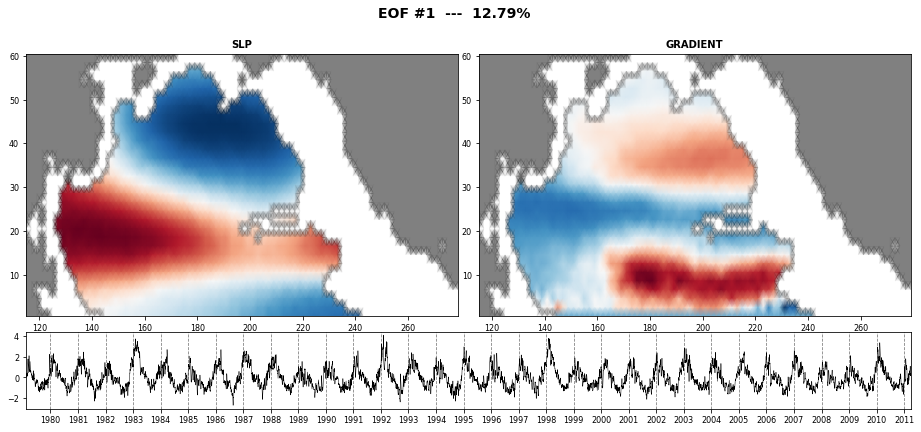

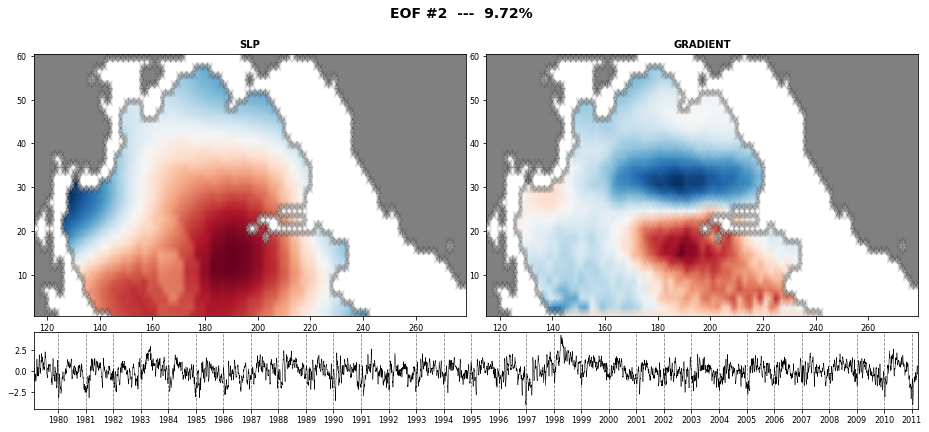

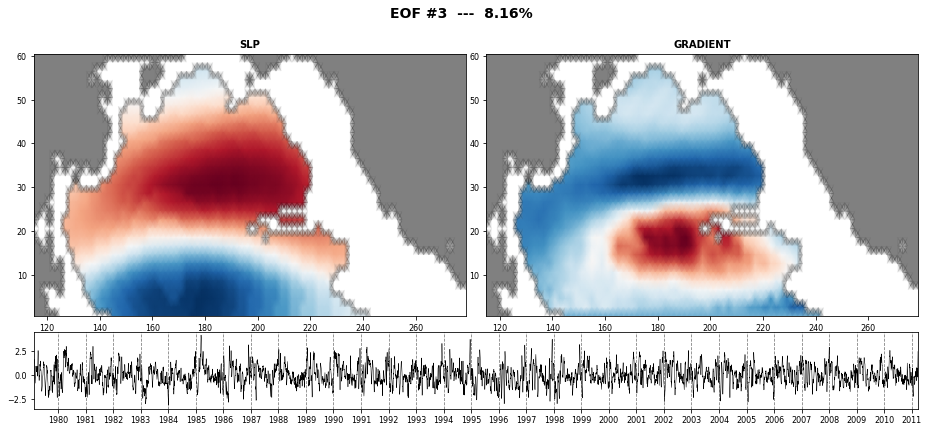

In [8]:
# plot PCA EOFs
n_EOFs = 3

pred.Plot_EOFs_EstelaPred(n_EOFs, show=True);



## ESTELA Predictor - KMeans Classification

In [9]:
# Calculate KMA (regression guided with WAVES data)
pred.Calc_KMA_regressionguided(
    num_clusters,
    WAVES_d, ['Hs','Tp','Fe'],
    kmarg_alpha, min_group_size=50,
)

print(pred.KMA)


  c: 2 - s: 49
  c: 5 - s: 47
  c: 10 - s: 22
  c: 11 - s: 10
  c: 12 - s: 6
  c: 14 - s: 11
  c: 15 - s: 6
  c: 16 - s: 6
  c: 20 - s: 14
  c: 24 - s: 22
  c: 26 - s: 7
total attemps:  1

  c: 0 - s: 9
  c: 1 - s: 7
  c: 10 - s: 21
  c: 11 - s: 2
  c: 13 - s: 22
  c: 14 - s: 22
  c: 18 - s: 17
  c: 19 - s: 1
  c: 21 - s: 3
  c: 23 - s: 21
  c: 29 - s: 7
  c: 33 - s: 2
  c: 34 - s: 3
  c: 35 - s: 4
total attemps:  2

  c: 13 - s: 4
  c: 25 - s: 11
  c: 26 - s: 20
  c: 31 - s: 25
total attemps:  3

  c: 17 - s: 6
  c: 25 - s: 3
  c: 29 - s: 32
  c: 30 - s: 14
  c: 34 - s: 4
total attemps:  4

  c: 10 - s: 32
  c: 11 - s: 19
  c: 14 - s: 10
  c: 15 - s: 46
  c: 28 - s: 39
total attemps:  5

  c: 17 - s: 20
  c: 19 - s: 25
  c: 25 - s: 22
  c: 31 - s: 9
  c: 35 - s: 44
total attemps:  6

  c: 7 - s: 10
  c: 10 - s: 41
  c: 13 - s: 38
  c: 16 - s: 20
  c: 18 - s: 9
  c: 20 - s: 11
  c: 25 - s: 15
  c: 26 - s: 8
  c: 27 - s: 12
  c: 28 - s: 16
  c: 32 - s: 8
  c: 33 - s: 16
total attemps:  

  c: 4 - s: 36
  c: 13 - s: 39
  c: 14 - s: 16
  c: 21 - s: 47
total attemps:  57

  c: 4 - s: 3
  c: 8 - s: 10
  c: 9 - s: 13
  c: 11 - s: 5
  c: 16 - s: 19
  c: 23 - s: 16
  c: 25 - s: 1
  c: 26 - s: 6
  c: 28 - s: 3
  c: 29 - s: 11
total attemps:  58

  c: 10 - s: 9
  c: 21 - s: 8
  c: 22 - s: 23
  c: 26 - s: 38
  c: 32 - s: 29
  c: 34 - s: 45
total attemps:  59

  c: 5 - s: 26
  c: 6 - s: 5
  c: 13 - s: 36
  c: 14 - s: 10
  c: 15 - s: 7
  c: 18 - s: 6
  c: 19 - s: 12
  c: 20 - s: 3
  c: 25 - s: 8
  c: 28 - s: 9
  c: 33 - s: 33
  c: 34 - s: 28
total attemps:  60

  c: 0 - s: 9
  c: 7 - s: 44
  c: 14 - s: 14
  c: 18 - s: 4
  c: 19 - s: 10
  c: 21 - s: 49
  c: 22 - s: 21
  c: 23 - s: 4
  c: 24 - s: 8
  c: 25 - s: 9
  c: 27 - s: 8
  c: 28 - s: 8
  c: 31 - s: 4
  c: 32 - s: 15
total attemps:  61

  c: 0 - s: 36
  c: 11 - s: 22
  c: 12 - s: 27
  c: 16 - s: 2
  c: 18 - s: 32
  c: 24 - s: 28
  c: 30 - s: 36
  c: 34 - s: 25
total attemps:  62

  c: 12 - s: 30
  c: 14 - s: 7
  c: 16 - s: 26


  c: 2 - s: 34
  c: 5 - s: 12
  c: 8 - s: 5
  c: 9 - s: 19
  c: 15 - s: 13
  c: 22 - s: 8
  c: 24 - s: 40
  c: 27 - s: 18
  c: 29 - s: 7
  c: 31 - s: 38
  c: 34 - s: 8
total attemps:  108

  c: 3 - s: 29
  c: 9 - s: 28
  c: 16 - s: 15
  c: 18 - s: 33
  c: 19 - s: 32
  c: 31 - s: 14
  c: 34 - s: 41
total attemps:  109

  c: 0 - s: 44
  c: 14 - s: 15
  c: 15 - s: 21
  c: 18 - s: 38
  c: 22 - s: 12
  c: 24 - s: 8
  c: 28 - s: 8
  c: 31 - s: 10
  c: 32 - s: 44
total attemps:  110

  c: 5 - s: 8
  c: 6 - s: 8
  c: 8 - s: 1
  c: 11 - s: 24
  c: 18 - s: 13
  c: 19 - s: 16
  c: 28 - s: 21
  c: 34 - s: 18
  c: 35 - s: 16
total attemps:  111

  c: 6 - s: 47
  c: 7 - s: 13
  c: 10 - s: 21
  c: 21 - s: 42
total attemps:  112

  c: 6 - s: 37
  c: 13 - s: 3
  c: 14 - s: 10
  c: 16 - s: 10
  c: 19 - s: 8
  c: 22 - s: 44
  c: 23 - s: 11
  c: 26 - s: 3
  c: 28 - s: 10
  c: 31 - s: 22
  c: 32 - s: 11
  c: 33 - s: 20
total attemps:  113

  c: 3 - s: 28
  c: 16 - s: 10
  c: 17 - s: 19
  c: 25 - s: 35
tota

  c: 0 - s: 31
  c: 13 - s: 28
  c: 23 - s: 20
  c: 26 - s: 16
  c: 30 - s: 20
total attemps:  159

  c: 6 - s: 19
  c: 15 - s: 32
  c: 21 - s: 32
  c: 22 - s: 31
  c: 26 - s: 31
  c: 30 - s: 6
  c: 31 - s: 19
  c: 32 - s: 49
total attemps:  160

  c: 0 - s: 41
  c: 7 - s: 33
  c: 9 - s: 12
  c: 15 - s: 25
  c: 20 - s: 11
  c: 26 - s: 7
total attemps:  161

  c: 4 - s: 22
  c: 7 - s: 17
  c: 10 - s: 20
  c: 12 - s: 10
  c: 13 - s: 8
  c: 14 - s: 8
  c: 21 - s: 6
  c: 22 - s: 10
  c: 24 - s: 5
  c: 29 - s: 29
  c: 33 - s: 12
  c: 35 - s: 25
total attemps:  162

  c: 0 - s: 1
  c: 4 - s: 33
  c: 9 - s: 14
  c: 10 - s: 9
  c: 11 - s: 31
  c: 16 - s: 9
  c: 19 - s: 37
  c: 24 - s: 17
  c: 31 - s: 27
  c: 34 - s: 3
total attemps:  163

  c: 0 - s: 29
  c: 13 - s: 3
  c: 22 - s: 14
  c: 26 - s: 11
  c: 27 - s: 26
  c: 35 - s: 22
total attemps:  164

  c: 6 - s: 23
  c: 12 - s: 3
  c: 20 - s: 16
  c: 21 - s: 9
  c: 25 - s: 35
  c: 30 - s: 45
total attemps:  165

  c: 5 - s: 14
  c: 8 - s: 23


  c: 3 - s: 13
  c: 16 - s: 17
  c: 18 - s: 23
  c: 29 - s: 37
  c: 34 - s: 20
  c: 35 - s: 30
total attemps:  213

  c: 13 - s: 21
  c: 17 - s: 34
  c: 18 - s: 5
  c: 21 - s: 5
  c: 22 - s: 4
  c: 23 - s: 23
  c: 24 - s: 8
  c: 25 - s: 13
  c: 26 - s: 33
  c: 28 - s: 17
  c: 29 - s: 4
  c: 30 - s: 36
  c: 35 - s: 2
total attemps:  214

  c: 3 - s: 20
  c: 5 - s: 21
  c: 7 - s: 8
  c: 8 - s: 43
  c: 11 - s: 10
  c: 12 - s: 15
  c: 17 - s: 28
  c: 23 - s: 8
  c: 25 - s: 30
  c: 28 - s: 3
  c: 29 - s: 2
total attemps:  215

  c: 17 - s: 30
  c: 21 - s: 35
total attemps:  216

  c: 0 - s: 7
  c: 7 - s: 23
  c: 9 - s: 19
  c: 12 - s: 7
  c: 13 - s: 9
  c: 14 - s: 3
  c: 17 - s: 11
  c: 18 - s: 6
  c: 19 - s: 30
  c: 26 - s: 17
  c: 28 - s: 5
  c: 30 - s: 5
  c: 34 - s: 29
  c: 35 - s: 36
total attemps:  217

  c: 3 - s: 10
  c: 6 - s: 44
  c: 13 - s: 7
  c: 23 - s: 36
  c: 24 - s: 31
  c: 28 - s: 43
  c: 33 - s: 12
  c: 34 - s: 21
  c: 35 - s: 15
total attemps:  218

  c: 8 - s: 39
  c: 9 

  c: 2 - s: 41
  c: 7 - s: 29
  c: 33 - s: 37
  c: 34 - s: 19
  c: 35 - s: 20
total attemps:  262

  c: 0 - s: 9
  c: 9 - s: 15
  c: 28 - s: 31
  c: 30 - s: 30
  c: 32 - s: 3
total attemps:  263

  c: 3 - s: 18
  c: 5 - s: 46
  c: 11 - s: 19
  c: 12 - s: 3
  c: 13 - s: 9
  c: 15 - s: 7
  c: 18 - s: 12
  c: 19 - s: 5
  c: 24 - s: 16
  c: 25 - s: 25
  c: 26 - s: 17
  c: 28 - s: 12
  c: 31 - s: 10
  c: 33 - s: 25
total attemps:  264

  c: 0 - s: 14
  c: 2 - s: 21
  c: 9 - s: 7
  c: 15 - s: 1
  c: 22 - s: 34
  c: 23 - s: 26
  c: 24 - s: 9
  c: 25 - s: 18
  c: 28 - s: 18
  c: 29 - s: 8
  c: 32 - s: 5
total attemps:  265

  c: 1 - s: 43
  c: 15 - s: 29
  c: 16 - s: 18
  c: 18 - s: 22
total attemps:  266

  c: 0 - s: 24
  c: 12 - s: 40
  c: 18 - s: 42
  c: 19 - s: 26
  c: 21 - s: 2
  c: 22 - s: 6
  c: 23 - s: 13
  c: 24 - s: 9
  c: 26 - s: 9
  c: 27 - s: 17
  c: 29 - s: 17
  c: 30 - s: 16
  c: 31 - s: 39
  c: 33 - s: 7
  c: 35 - s: 6
total attemps:  267

  c: 0 - s: 32
  c: 9 - s: 37
  c: 15 

  c: 6 - s: 39
  c: 17 - s: 17
  c: 21 - s: 31
  c: 22 - s: 13
  c: 23 - s: 39
  c: 26 - s: 24
  c: 28 - s: 3
  c: 31 - s: 17
  c: 32 - s: 32
total attemps:  309

  c: 8 - s: 18
  c: 12 - s: 6
  c: 19 - s: 2
  c: 25 - s: 49
  c: 26 - s: 23
  c: 27 - s: 21
  c: 28 - s: 47
  c: 31 - s: 31
total attemps:  310

  c: 8 - s: 17
  c: 14 - s: 38
  c: 24 - s: 3
  c: 28 - s: 25
  c: 31 - s: 24
total attemps:  311

  c: 3 - s: 27
  c: 8 - s: 17
  c: 12 - s: 11
  c: 17 - s: 11
  c: 18 - s: 11
  c: 24 - s: 20
total attemps:  312

  c: 5 - s: 43
  c: 6 - s: 6
  c: 9 - s: 7
  c: 16 - s: 4
  c: 17 - s: 14
  c: 20 - s: 31
  c: 27 - s: 31
  c: 31 - s: 21
  c: 32 - s: 43
  c: 33 - s: 4
  c: 34 - s: 20
total attemps:  313

  c: 0 - s: 41
  c: 10 - s: 6
  c: 14 - s: 48
  c: 17 - s: 33
  c: 18 - s: 46
  c: 19 - s: 5
  c: 25 - s: 5
  c: 27 - s: 14
total attemps:  314

  c: 4 - s: 15
  c: 11 - s: 23
  c: 15 - s: 29
  c: 20 - s: 29
  c: 21 - s: 48
  c: 23 - s: 35
  c: 26 - s: 29
  c: 33 - s: 43
  c: 34 - s: 47

  c: 11 - s: 47
  c: 13 - s: 9
  c: 14 - s: 17
  c: 15 - s: 40
  c: 16 - s: 15
  c: 21 - s: 11
  c: 24 - s: 18
  c: 28 - s: 12
  c: 32 - s: 7
  c: 34 - s: 8
total attemps:  363

  c: 13 - s: 36
  c: 15 - s: 17
  c: 16 - s: 9
  c: 30 - s: 12
  c: 33 - s: 48
total attemps:  364

  c: 4 - s: 4
  c: 6 - s: 5
  c: 11 - s: 6
  c: 13 - s: 35
  c: 19 - s: 18
  c: 20 - s: 3
  c: 25 - s: 6
  c: 26 - s: 27
  c: 28 - s: 12
  c: 29 - s: 2
  c: 30 - s: 10
  c: 33 - s: 14
  c: 35 - s: 7
total attemps:  365

  c: 2 - s: 27
  c: 7 - s: 19
  c: 10 - s: 7
  c: 12 - s: 15
  c: 15 - s: 4
  c: 17 - s: 41
  c: 18 - s: 8
  c: 19 - s: 4
  c: 23 - s: 33
  c: 24 - s: 32
  c: 26 - s: 2
  c: 32 - s: 38
  c: 33 - s: 8
total attemps:  366

  c: 3 - s: 10
  c: 5 - s: 12
  c: 7 - s: 7
  c: 11 - s: 7
  c: 12 - s: 30
  c: 13 - s: 26
  c: 19 - s: 13
  c: 20 - s: 11
  c: 22 - s: 7
  c: 24 - s: 13
  c: 26 - s: 11
  c: 28 - s: 32
  c: 29 - s: 23
  c: 30 - s: 17
  c: 31 - s: 3
  c: 33 - s: 16
  c: 35 - s: 16
total attemps:  

  c: 3 - s: 38
  c: 6 - s: 4
  c: 21 - s: 21
  c: 24 - s: 20
  c: 30 - s: 9
total attemps:  413

  c: 1 - s: 3
  c: 7 - s: 5
  c: 8 - s: 5
  c: 10 - s: 12
  c: 13 - s: 11
  c: 14 - s: 9
  c: 16 - s: 33
  c: 17 - s: 30
  c: 22 - s: 7
  c: 24 - s: 46
  c: 25 - s: 4
  c: 26 - s: 19
  c: 27 - s: 27
  c: 30 - s: 6
  c: 35 - s: 12
total attemps:  414

  c: 10 - s: 7
  c: 13 - s: 31
  c: 18 - s: 4
  c: 19 - s: 40
  c: 23 - s: 36
  c: 24 - s: 30
  c: 26 - s: 29
total attemps:  415

  c: 16 - s: 27
  c: 24 - s: 9
  c: 29 - s: 17
  c: 34 - s: 6
  c: 35 - s: 23
total attemps:  416

  c: 0 - s: 20
  c: 18 - s: 30
  c: 20 - s: 7
  c: 21 - s: 7
  c: 26 - s: 8
  c: 28 - s: 7
  c: 33 - s: 35
  c: 34 - s: 3
  c: 35 - s: 35
total attemps:  417

  c: 0 - s: 11
  c: 5 - s: 28
  c: 6 - s: 17
  c: 14 - s: 28
  c: 16 - s: 18
  c: 17 - s: 3
  c: 18 - s: 12
  c: 20 - s: 6
  c: 25 - s: 3
  c: 29 - s: 9
  c: 32 - s: 25
  c: 33 - s: 18
  c: 35 - s: 9
total attemps:  418

  c: 1 - s: 37
  c: 16 - s: 25
  c: 17 - s

  c: 5 - s: 40
  c: 11 - s: 41
  c: 16 - s: 4
  c: 20 - s: 40
  c: 24 - s: 14
  c: 32 - s: 46
  c: 34 - s: 24
total attemps:  466

  c: 0 - s: 21
  c: 7 - s: 38
  c: 11 - s: 46
  c: 14 - s: 47
  c: 17 - s: 33
  c: 24 - s: 7
  c: 26 - s: 16
  c: 28 - s: 6
  c: 35 - s: 43
total attemps:  467

  c: 9 - s: 29
  c: 14 - s: 34
  c: 28 - s: 9
  c: 30 - s: 41
  c: 34 - s: 48
  c: 35 - s: 40
total attemps:  468

  c: 9 - s: 40
  c: 10 - s: 27
  c: 12 - s: 26
  c: 22 - s: 40
  c: 30 - s: 18
total attemps:  469

  c: 2 - s: 11
  c: 14 - s: 20
  c: 17 - s: 6
  c: 19 - s: 1
  c: 22 - s: 3
  c: 27 - s: 11
  c: 29 - s: 13
  c: 35 - s: 16
total attemps:  470

  c: 16 - s: 6
  c: 17 - s: 4
  c: 18 - s: 4
  c: 20 - s: 22
  c: 23 - s: 5
  c: 25 - s: 12
  c: 27 - s: 26
  c: 28 - s: 4
  c: 30 - s: 22
  c: 31 - s: 3
  c: 32 - s: 10
total attemps:  471

  c: 15 - s: 21
  c: 17 - s: 31
  c: 19 - s: 1
  c: 21 - s: 33
  c: 30 - s: 30
  c: 31 - s: 15
  c: 34 - s: 14
total attemps:  472

  c: 0 - s: 27
  c: 28 - 

  c: 0 - s: 13
  c: 1 - s: 23
  c: 6 - s: 4
  c: 12 - s: 6
  c: 16 - s: 2
  c: 17 - s: 8
  c: 20 - s: 43
  c: 21 - s: 25
  c: 24 - s: 7
  c: 26 - s: 10
  c: 27 - s: 26
  c: 28 - s: 20
  c: 30 - s: 5
  c: 32 - s: 39
  c: 33 - s: 37
  c: 34 - s: 42
  c: 35 - s: 15
total attemps:  521

  c: 7 - s: 3
  c: 13 - s: 10
  c: 17 - s: 1
  c: 18 - s: 12
  c: 20 - s: 25
  c: 23 - s: 2
  c: 25 - s: 4
  c: 29 - s: 6
  c: 30 - s: 6
  c: 34 - s: 7
total attemps:  522

  c: 9 - s: 17
  c: 11 - s: 22
  c: 13 - s: 24
  c: 20 - s: 26
  c: 25 - s: 8
  c: 26 - s: 33
  c: 29 - s: 46
  c: 31 - s: 7
total attemps:  523

  c: 7 - s: 30
  c: 11 - s: 6
  c: 15 - s: 12
  c: 19 - s: 36
  c: 22 - s: 25
  c: 23 - s: 29
  c: 24 - s: 24
  c: 27 - s: 20
  c: 28 - s: 47
  c: 35 - s: 8
total attemps:  524

  c: 6 - s: 17
  c: 9 - s: 5
  c: 12 - s: 27
  c: 16 - s: 5
  c: 20 - s: 17
total attemps:  525

  c: 13 - s: 38
  c: 18 - s: 29
  c: 21 - s: 23
total attemps:  526

  c: 13 - s: 15
  c: 15 - s: 25
  c: 21 - s: 42
  c: 

  c: 0 - s: 9
  c: 8 - s: 34
  c: 18 - s: 6
  c: 23 - s: 3
  c: 24 - s: 4
  c: 25 - s: 9
  c: 26 - s: 2
  c: 27 - s: 5
  c: 28 - s: 5
  c: 29 - s: 5
total attemps:  572

  c: 1 - s: 32
  c: 7 - s: 46
  c: 12 - s: 6
  c: 31 - s: 43
total attemps:  573

  c: 10 - s: 35
  c: 29 - s: 39
  c: 31 - s: 28
  c: 35 - s: 4
total attemps:  574

  c: 0 - s: 13
  c: 8 - s: 11
  c: 17 - s: 15
  c: 23 - s: 44
  c: 24 - s: 20
  c: 25 - s: 20
  c: 26 - s: 28
total attemps:  575

  c: 6 - s: 34
  c: 13 - s: 39
  c: 16 - s: 29
  c: 18 - s: 30
  c: 23 - s: 24
  c: 25 - s: 6
  c: 29 - s: 18
  c: 30 - s: 10
  c: 33 - s: 18
total attemps:  576

  c: 4 - s: 3
  c: 19 - s: 41
  c: 20 - s: 35
  c: 21 - s: 20
  c: 26 - s: 4
  c: 29 - s: 19
  c: 31 - s: 21
  c: 34 - s: 28
total attemps:  577

  c: 11 - s: 34
  c: 14 - s: 16
  c: 18 - s: 9
  c: 19 - s: 12
  c: 20 - s: 12
  c: 21 - s: 6
  c: 25 - s: 4
  c: 27 - s: 16
  c: 30 - s: 8
  c: 31 - s: 17
  c: 32 - s: 28
  c: 34 - s: 19
total attemps:  578

  c: 7 - s: 16


  c: 3 - s: 17
  c: 12 - s: 3
  c: 13 - s: 2
  c: 14 - s: 9
  c: 19 - s: 44
  c: 29 - s: 8
  c: 30 - s: 24
  c: 31 - s: 21
  c: 32 - s: 38
  c: 33 - s: 7
  c: 35 - s: 27
total attemps:  626

  c: 13 - s: 28
  c: 26 - s: 21
  c: 29 - s: 28
total attemps:  627

  c: 4 - s: 35
  c: 16 - s: 6
  c: 19 - s: 20
  c: 21 - s: 6
  c: 22 - s: 30
total attemps:  628

  c: 6 - s: 28
  c: 8 - s: 29
  c: 12 - s: 46
  c: 15 - s: 10
  c: 16 - s: 12
  c: 17 - s: 5
  c: 19 - s: 43
  c: 23 - s: 5
  c: 24 - s: 3
  c: 25 - s: 6
  c: 28 - s: 18
  c: 31 - s: 19
  c: 32 - s: 4
  c: 34 - s: 5
total attemps:  629

  c: 1 - s: 12
  c: 20 - s: 29
  c: 24 - s: 35
  c: 30 - s: 34
  c: 31 - s: 36
total attemps:  630

  c: 2 - s: 34
  c: 8 - s: 45
  c: 14 - s: 7
  c: 15 - s: 37
  c: 23 - s: 44
total attemps:  631

  c: 19 - s: 29
  c: 20 - s: 3
  c: 25 - s: 17
  c: 28 - s: 25
  c: 29 - s: 24
total attemps:  632

  c: 15 - s: 42
  c: 16 - s: 44
  c: 19 - s: 11
  c: 21 - s: 43
  c: 25 - s: 10
  c: 26 - s: 31
  c: 28 - s

  c: 0 - s: 7
  c: 12 - s: 27
  c: 17 - s: 3
  c: 20 - s: 47
  c: 28 - s: 3
total attemps:  683

  c: 7 - s: 33
  c: 13 - s: 40
  c: 21 - s: 41
  c: 22 - s: 25
  c: 25 - s: 34
total attemps:  684

  c: 0 - s: 26
  c: 5 - s: 31
  c: 7 - s: 48
  c: 11 - s: 11
  c: 16 - s: 4
  c: 19 - s: 35
  c: 20 - s: 10
  c: 21 - s: 8
  c: 23 - s: 27
  c: 25 - s: 17
  c: 27 - s: 11
  c: 29 - s: 31
  c: 31 - s: 5
  c: 33 - s: 5
total attemps:  685

  c: 4 - s: 12
  c: 5 - s: 3
  c: 8 - s: 5
  c: 10 - s: 23
  c: 11 - s: 12
  c: 15 - s: 37
  c: 23 - s: 3
  c: 24 - s: 2
  c: 25 - s: 8
  c: 26 - s: 9
  c: 29 - s: 30
  c: 33 - s: 24
  c: 34 - s: 9
total attemps:  686

  c: 2 - s: 31
  c: 16 - s: 18
  c: 19 - s: 28
  c: 20 - s: 32
  c: 21 - s: 6
  c: 28 - s: 49
  c: 30 - s: 8
  c: 31 - s: 9
  c: 32 - s: 30
total attemps:  687

  c: 0 - s: 2
  c: 1 - s: 24
  c: 15 - s: 9
  c: 17 - s: 24
  c: 22 - s: 5
  c: 25 - s: 36
  c: 29 - s: 18
  c: 30 - s: 23
  c: 31 - s: 25
  c: 32 - s: 38
  c: 34 - s: 2
total attemps: 

  c: 6 - s: 35
  c: 7 - s: 19
  c: 10 - s: 12
  c: 12 - s: 3
  c: 14 - s: 13
  c: 17 - s: 49
  c: 18 - s: 4
  c: 21 - s: 14
  c: 26 - s: 6
  c: 28 - s: 3
  c: 29 - s: 2
  c: 30 - s: 7
  c: 33 - s: 5
  c: 34 - s: 5
  c: 35 - s: 6
total attemps:  736

  c: 21 - s: 21
  c: 27 - s: 36
  c: 31 - s: 40
total attemps:  737

  c: 5 - s: 8
  c: 15 - s: 24
  c: 16 - s: 39
  c: 20 - s: 4
  c: 22 - s: 4
  c: 23 - s: 8
  c: 25 - s: 15
  c: 28 - s: 26
  c: 30 - s: 9
  c: 32 - s: 3
  c: 34 - s: 23
  c: 35 - s: 5
total attemps:  738

  c: 0 - s: 6
  c: 8 - s: 43
  c: 10 - s: 2
  c: 14 - s: 7
  c: 20 - s: 46
  c: 23 - s: 20
  c: 27 - s: 18
  c: 30 - s: 3
total attemps:  739

  c: 0 - s: 34
  c: 6 - s: 11
  c: 9 - s: 19
  c: 18 - s: 12
  c: 25 - s: 44
  c: 34 - s: 20
  c: 35 - s: 21
total attemps:  740

  c: 0 - s: 2
  c: 8 - s: 12
  c: 10 - s: 21
  c: 11 - s: 31
  c: 14 - s: 7
  c: 16 - s: 14
  c: 17 - s: 5
  c: 18 - s: 15
  c: 19 - s: 12
  c: 25 - s: 17
  c: 26 - s: 11
  c: 27 - s: 13
  c: 28 - s: 4
 

  c: 10 - s: 21
  c: 19 - s: 6
  c: 26 - s: 33
  c: 35 - s: 4
total attemps:  788

  c: 6 - s: 21
  c: 23 - s: 2
  c: 25 - s: 16
  c: 26 - s: 10
  c: 29 - s: 34
total attemps:  789

  c: 11 - s: 5
  c: 12 - s: 15
  c: 13 - s: 2
  c: 17 - s: 30
  c: 19 - s: 22
  c: 27 - s: 33
  c: 35 - s: 18
total attemps:  790

  c: 14 - s: 26
  c: 15 - s: 1
  c: 18 - s: 37
  c: 21 - s: 4
  c: 22 - s: 10
  c: 25 - s: 13
  c: 26 - s: 17
  c: 30 - s: 12
total attemps:  791

  c: 4 - s: 15
  c: 5 - s: 45
  c: 8 - s: 14
  c: 10 - s: 2
  c: 12 - s: 2
  c: 20 - s: 5
  c: 21 - s: 49
  c: 22 - s: 9
  c: 23 - s: 9
  c: 25 - s: 12
  c: 26 - s: 3
  c: 27 - s: 5
  c: 30 - s: 9
  c: 32 - s: 10
total attemps:  792

  c: 4 - s: 17
  c: 7 - s: 5
  c: 11 - s: 32
  c: 13 - s: 38
  c: 15 - s: 33
  c: 18 - s: 41
  c: 23 - s: 5
  c: 27 - s: 3
  c: 29 - s: 3
  c: 30 - s: 5
  c: 32 - s: 34
  c: 34 - s: 4
  c: 35 - s: 5
total attemps:  793

  c: 3 - s: 31
  c: 5 - s: 10
  c: 10 - s: 30
  c: 13 - s: 29
  c: 15 - s: 13
  c: 18 

  c: 12 - s: 8
  c: 26 - s: 23
  c: 27 - s: 36
  c: 29 - s: 35
total attemps:  838

  c: 4 - s: 37
  c: 18 - s: 6
  c: 21 - s: 13
  c: 23 - s: 11
  c: 27 - s: 17
  c: 29 - s: 8
  c: 32 - s: 33
  c: 33 - s: 14
  c: 34 - s: 30
  c: 35 - s: 7
total attemps:  839

  c: 11 - s: 35
  c: 20 - s: 10
  c: 24 - s: 5
  c: 26 - s: 45
  c: 28 - s: 5
total attemps:  840

  c: 1 - s: 4
  c: 6 - s: 4
  c: 7 - s: 17
  c: 8 - s: 45
  c: 11 - s: 36
  c: 13 - s: 19
  c: 14 - s: 5
  c: 16 - s: 5
  c: 21 - s: 25
  c: 28 - s: 26
  c: 29 - s: 15
  c: 33 - s: 11
  c: 34 - s: 9
  c: 35 - s: 4
total attemps:  841

  c: 11 - s: 29
  c: 12 - s: 41
  c: 13 - s: 25
  c: 14 - s: 14
  c: 24 - s: 36
  c: 26 - s: 10
  c: 27 - s: 31
  c: 34 - s: 39
total attemps:  842

  c: 0 - s: 3
  c: 5 - s: 15
  c: 10 - s: 33
  c: 18 - s: 14
  c: 19 - s: 5
  c: 23 - s: 48
  c: 24 - s: 28
  c: 25 - s: 7
  c: 28 - s: 28
total attemps:  843

  c: 3 - s: 11
  c: 6 - s: 7
  c: 7 - s: 7
  c: 11 - s: 11
  c: 12 - s: 7
  c: 14 - s: 8
  c: 16

  c: 6 - s: 8
  c: 7 - s: 15
  c: 11 - s: 7
  c: 14 - s: 5
  c: 15 - s: 20
  c: 16 - s: 26
  c: 18 - s: 5
  c: 24 - s: 17
  c: 26 - s: 8
  c: 29 - s: 4
  c: 30 - s: 7
  c: 32 - s: 13
  c: 33 - s: 4
  c: 35 - s: 4
total attemps:  890

  c: 10 - s: 15
  c: 11 - s: 36
  c: 25 - s: 45
  c: 26 - s: 45
  c: 32 - s: 14
  c: 35 - s: 6
total attemps:  891

  c: 6 - s: 29
  c: 7 - s: 10
  c: 14 - s: 5
  c: 17 - s: 2
  c: 20 - s: 21
  c: 24 - s: 21
  c: 26 - s: 9
  c: 28 - s: 22
total attemps:  892

  c: 12 - s: 10
  c: 26 - s: 27
  c: 29 - s: 20
  c: 30 - s: 32
total attemps:  893

  c: 2 - s: 4
  c: 8 - s: 11
  c: 12 - s: 8
  c: 13 - s: 8
  c: 15 - s: 34
  c: 16 - s: 4
  c: 20 - s: 6
  c: 24 - s: 7
  c: 25 - s: 43
  c: 26 - s: 10
  c: 27 - s: 21
  c: 30 - s: 21
  c: 33 - s: 17
  c: 34 - s: 11
  c: 35 - s: 24
total attemps:  894

  c: 2 - s: 5
  c: 5 - s: 16
  c: 10 - s: 13
  c: 11 - s: 39
  c: 14 - s: 28
  c: 16 - s: 6
  c: 19 - s: 6
  c: 20 - s: 4
  c: 25 - s: 6
  c: 30 - s: 15
  c: 31 - s: 6


  c: 17 - s: 27
  c: 22 - s: 31
  c: 25 - s: 11
  c: 28 - s: 9
  c: 34 - s: 4
total attemps:  942

  c: 6 - s: 33
  c: 12 - s: 37
  c: 17 - s: 16
  c: 18 - s: 26
  c: 29 - s: 19
  c: 30 - s: 9
  c: 35 - s: 37
total attemps:  943

  c: 0 - s: 33
  c: 9 - s: 14
  c: 13 - s: 31
  c: 18 - s: 26
  c: 19 - s: 11
  c: 22 - s: 7
  c: 24 - s: 8
  c: 25 - s: 15
  c: 30 - s: 10
  c: 33 - s: 16
total attemps:  944

  c: 6 - s: 19
  c: 8 - s: 21
  c: 21 - s: 13
  c: 27 - s: 5
total attemps:  945

  c: 18 - s: 3
  c: 20 - s: 2
  c: 23 - s: 18
  c: 27 - s: 7
  c: 28 - s: 16
  c: 29 - s: 13
  c: 30 - s: 14
  c: 32 - s: 19
  c: 34 - s: 10
  c: 35 - s: 6
total attemps:  946

  c: 3 - s: 9
  c: 4 - s: 12
  c: 5 - s: 2
  c: 10 - s: 39
  c: 18 - s: 11
  c: 19 - s: 7
  c: 23 - s: 5
  c: 24 - s: 20
  c: 25 - s: 16
  c: 26 - s: 17
  c: 29 - s: 3
total attemps:  947

  c: 2 - s: 5
  c: 4 - s: 42
  c: 7 - s: 9
  c: 12 - s: 8
  c: 16 - s: 5
  c: 18 - s: 11
  c: 25 - s: 13
  c: 26 - s: 17
  c: 28 - s: 9
  c: 30 -

  c: 0 - s: 5
  c: 4 - s: 4
  c: 6 - s: 22
  c: 9 - s: 5
  c: 10 - s: 12
  c: 14 - s: 27
  c: 16 - s: 12
  c: 21 - s: 16
  c: 22 - s: 12
  c: 23 - s: 10
  c: 25 - s: 9
  c: 26 - s: 11
  c: 28 - s: 9
  c: 29 - s: 20
  c: 30 - s: 10
  c: 31 - s: 4
total attemps:  991

  c: 8 - s: 21
  c: 12 - s: 35
  c: 14 - s: 21
  c: 15 - s: 20
  c: 18 - s: 42
  c: 27 - s: 32
  c: 28 - s: 8
  c: 30 - s: 8
  c: 31 - s: 6
total attemps:  992

  c: 2 - s: 35
  c: 4 - s: 10
  c: 15 - s: 42
  c: 16 - s: 8
  c: 17 - s: 20
  c: 25 - s: 16
  c: 26 - s: 26
  c: 32 - s: 33
total attemps:  993

  c: 7 - s: 21
  c: 8 - s: 5
  c: 10 - s: 12
  c: 17 - s: 16
  c: 18 - s: 24
  c: 20 - s: 14
  c: 22 - s: 6
  c: 23 - s: 12
  c: 28 - s: 36
  c: 32 - s: 40
  c: 33 - s: 3
  c: 34 - s: 3
total attemps:  994

  c: 16 - s: 20
  c: 20 - s: 8
  c: 23 - s: 13
  c: 29 - s: 38
  c: 35 - s: 12
total attemps:  995

  c: 0 - s: 4
  c: 2 - s: 5
  c: 5 - s: 2
  c: 11 - s: 11
  c: 15 - s: 16
  c: 20 - s: 10
  c: 22 - s: 8
  c: 23 - s: 5

  c: 0 - s: 20
  c: 26 - s: 13
  c: 31 - s: 17
  c: 34 - s: 24
total attemps:  1039

  c: 3 - s: 42
  c: 5 - s: 12
  c: 10 - s: 19
  c: 13 - s: 14
  c: 18 - s: 2
  c: 23 - s: 13
  c: 31 - s: 5
  c: 33 - s: 4
total attemps:  1040

  c: 4 - s: 10
  c: 5 - s: 9
  c: 14 - s: 8
  c: 17 - s: 35
  c: 20 - s: 7
  c: 27 - s: 7
  c: 28 - s: 26
  c: 29 - s: 26
  c: 31 - s: 15
total attemps:  1041

  c: 6 - s: 32
  c: 8 - s: 14
  c: 10 - s: 22
  c: 14 - s: 39
  c: 16 - s: 12
  c: 17 - s: 17
  c: 21 - s: 10
  c: 22 - s: 8
  c: 23 - s: 5
  c: 26 - s: 7
  c: 27 - s: 8
  c: 33 - s: 11
  c: 35 - s: 6
total attemps:  1042

  c: 5 - s: 32
  c: 21 - s: 49
  c: 26 - s: 2
total attemps:  1043

  c: 3 - s: 46
  c: 7 - s: 38
  c: 14 - s: 48
  c: 17 - s: 21
  c: 25 - s: 15
  c: 26 - s: 39
  c: 30 - s: 31
  c: 35 - s: 21
total attemps:  1044

  c: 7 - s: 14
  c: 10 - s: 15
  c: 15 - s: 15
  c: 16 - s: 8
  c: 18 - s: 1
  c: 20 - s: 8
  c: 22 - s: 21
  c: 24 - s: 26
  c: 26 - s: 13
  c: 27 - s: 15
  c: 34 - s: 10

  c: 6 - s: 10
  c: 21 - s: 2
  c: 30 - s: 24
  c: 32 - s: 5
  c: 33 - s: 2
  c: 34 - s: 16
  c: 35 - s: 12
total attemps:  1094

  c: 1 - s: 26
  c: 2 - s: 14
  c: 5 - s: 32
  c: 8 - s: 1
  c: 10 - s: 11
  c: 14 - s: 6
  c: 18 - s: 15
  c: 20 - s: 5
  c: 22 - s: 14
  c: 23 - s: 11
  c: 27 - s: 25
  c: 28 - s: 28
  c: 31 - s: 3
  c: 32 - s: 10
  c: 34 - s: 1
  c: 35 - s: 16
total attemps:  1095

  c: 13 - s: 22
  c: 24 - s: 41
  c: 27 - s: 18
  c: 31 - s: 46
  c: 32 - s: 37
  c: 33 - s: 40
  c: 34 - s: 14
total attemps:  1096

  c: 21 - s: 17
  c: 34 - s: 36
total attemps:  1097

  c: 3 - s: 15
  c: 5 - s: 32
  c: 8 - s: 7
  c: 13 - s: 22
  c: 14 - s: 35
  c: 16 - s: 16
  c: 34 - s: 23
total attemps:  1098

  c: 10 - s: 8
  c: 11 - s: 18
  c: 13 - s: 39
  c: 15 - s: 22
  c: 19 - s: 35
  c: 26 - s: 33
  c: 27 - s: 36
  c: 35 - s: 14
total attemps:  1099

  c: 21 - s: 14
  c: 23 - s: 6
  c: 25 - s: 7
  c: 27 - s: 21
  c: 31 - s: 10
  c: 32 - s: 16
total attemps:  1100

  c: 0 - s: 18
  c

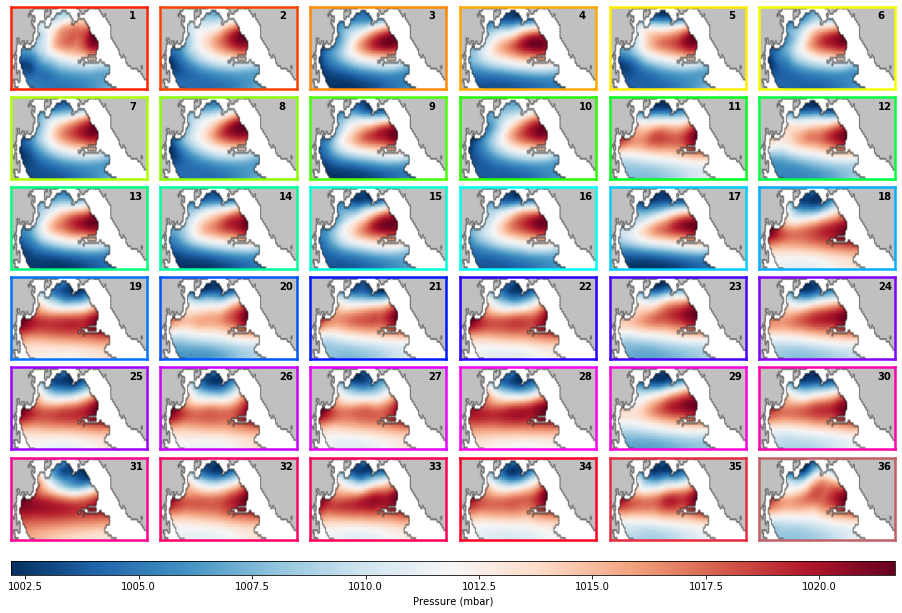

In [10]:
# Plot DWTs (data mean)
pred.Plot_DWTs('SLP', kind='mean', show=True);


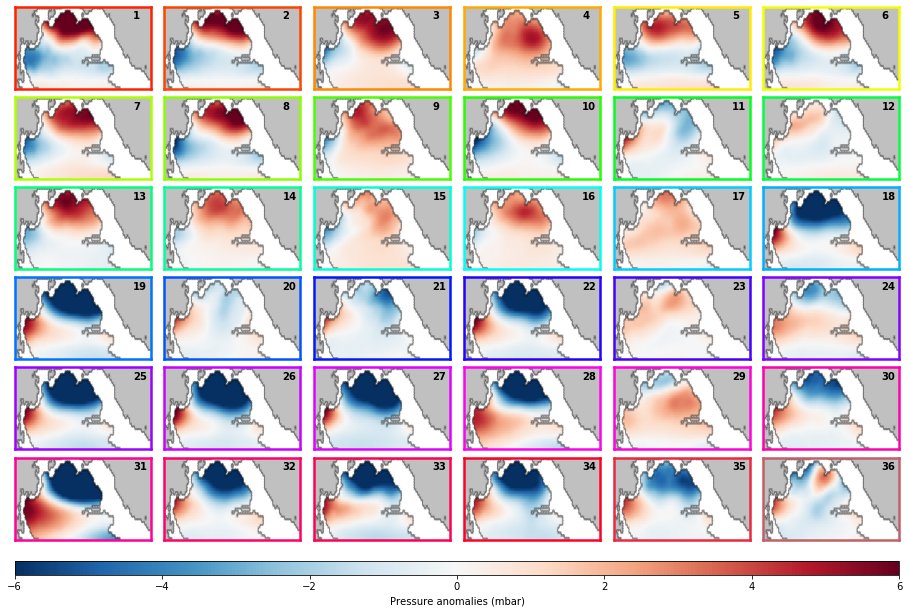

In [11]:
# Plot DWTs (data anomalies)
pred.Plot_DWTs('SLP', kind='anom', show=True);


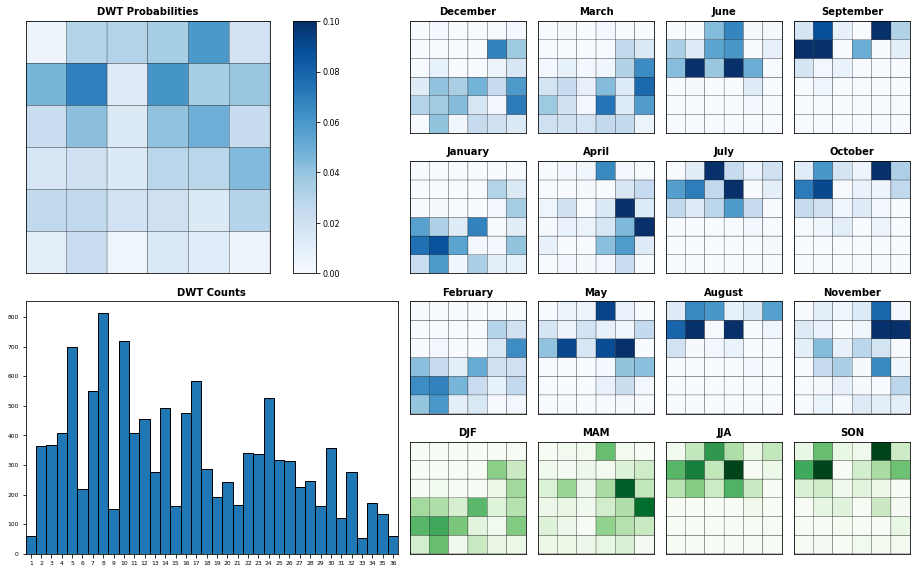

In [12]:
# Plot DWTs Probabilities
pred.Plot_DWTs_Probs();


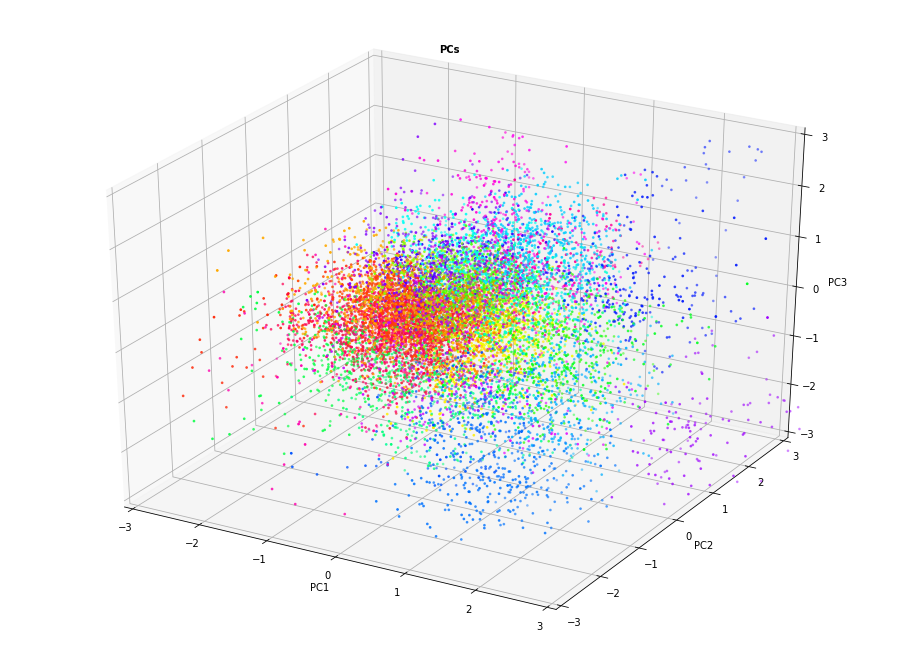

In [13]:
# Plot PC1, PC2, PC3 (3D)
pred.Plot_PCs_3D();


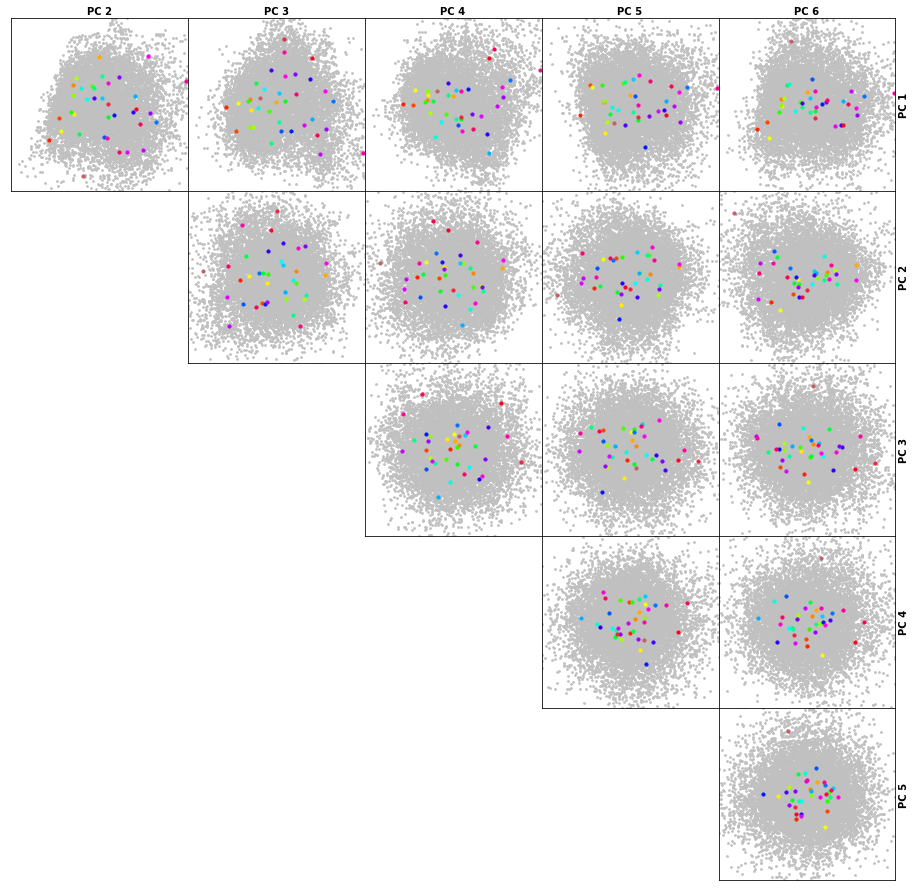

In [14]:
# Plot PCs DWT centroids
pred.Plot_DWT_PCs(n=6);



## ESTELA Predictor - Add Historical TCs

In [15]:
# --------------------------------------
# use historical storms-parameters inside r1 to modify predictor KMA results 

storm_dates = TCs_r1_params.dmin_date.values[:]
storm_categs = TCs_r1_params.category.values[:]

# add r1 storms to predictor KMA
pred.Mod_KMA_AddStorms(storm_dates, storm_categs)

print(pred.KMA)

<xarray.Dataset>
Dimensions:             (n_clusters: 36, n_components: 11736, n_features: 237)
Dimensions without coordinates: n_clusters, n_components, n_features
Data variables:
    bmus                (n_components) int32 9 14 14 14 35 35 ... 19 19 22 22 22
    cenEOFs             (n_clusters, n_features) float64 -0.5866 ... 0.799
    centroids           (n_clusters, n_features) float64 -14.0 -4.587 ... 4.742
    group_size          (n_clusters) int64 700 192 339 812 ... 243 277 122 172
    sorted_order        (n_clusters) int64 31 17 7 26 0 29 ... 34 8 30 35 19 16
    sorted_bmus         (n_components) int64 29 22 22 22 33 ... 34 34 28 28 28
    sorted_cenEOFs      (n_clusters, n_features) float64 -1.093 ... 0.3793
    sorted_centroids    (n_clusters, n_features) float64 -27.79 -17.52 ... 3.946
    time                (n_components) datetime64[ns] 1979-02-12 ... 2011-03-31
    sorted_bmus_storms  (n_components) int64 29 22 22 22 33 ... 34 34 28 28 28
Attributes:
    method:   regr

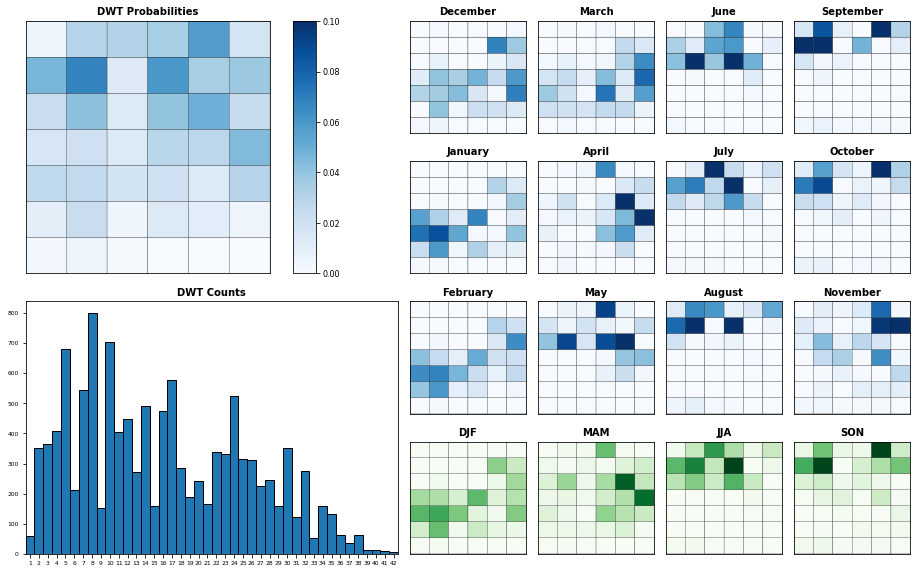

In [16]:
# Plot DWTs Probabilities with updated bmus
pred.Plot_DWTs_Probs(field='sorted_bmus_storms', n_clusters=42);


In [17]:
# --------------------------------------
# Calculate intradaily MU TAU hydrographs

l_MU_TAU = pred.Calc_MU_TAU_Hydrographs(WAVES)

# store hydrographs MU TAU
db.Save_MU_TAU_hydrograms(l_MU_TAU)


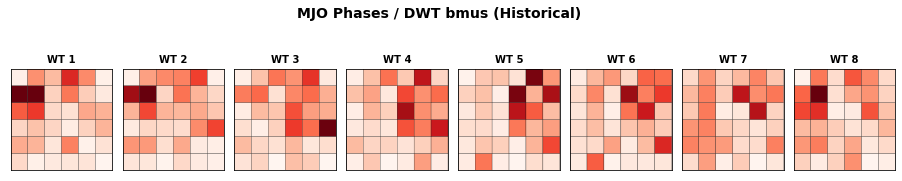

In [18]:
# Plot MJO phases / DWTs Probabilities 

# num. MJO phases and DWTs
MJO_ncs = 8
DWT_ncs = 36

# MJO, DWTs historical data
MJO_hist, DWT_hist = db.Load_MJO_DWTs_Plots_hist()

# categories to plot
MJO_phase = MJO_hist.phase.values[:]
DWT_bmus =  DWT_hist.bmus.values[:]

Plot_Probs_WT_WT(
    MJO_phase, DWT_bmus, MJO_ncs, DWT_ncs,
    wt_colors=False, ttl='MJO Phases / DWT bmus (Historical)');


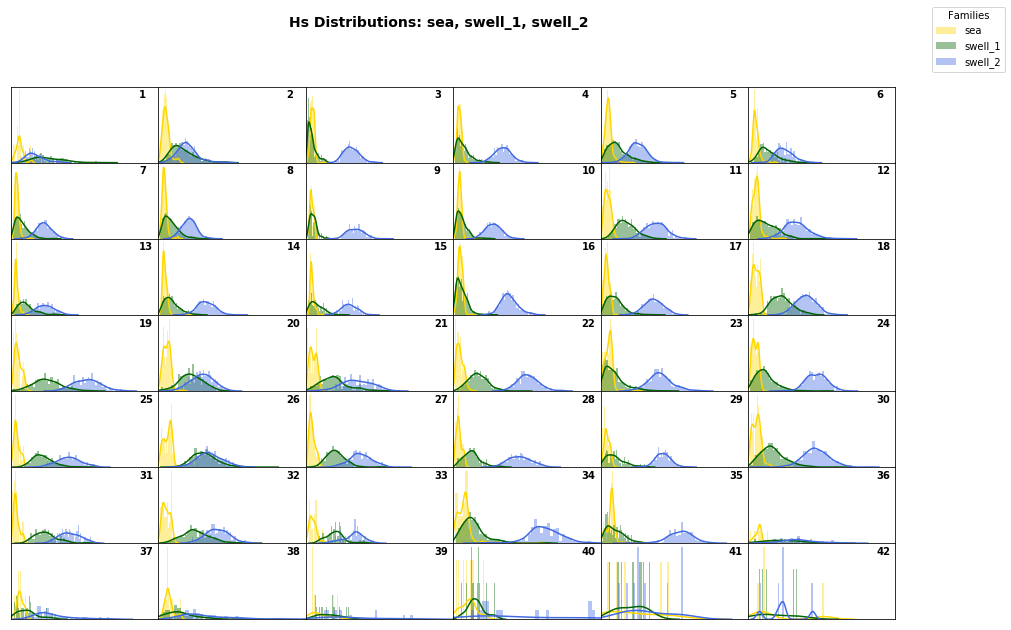

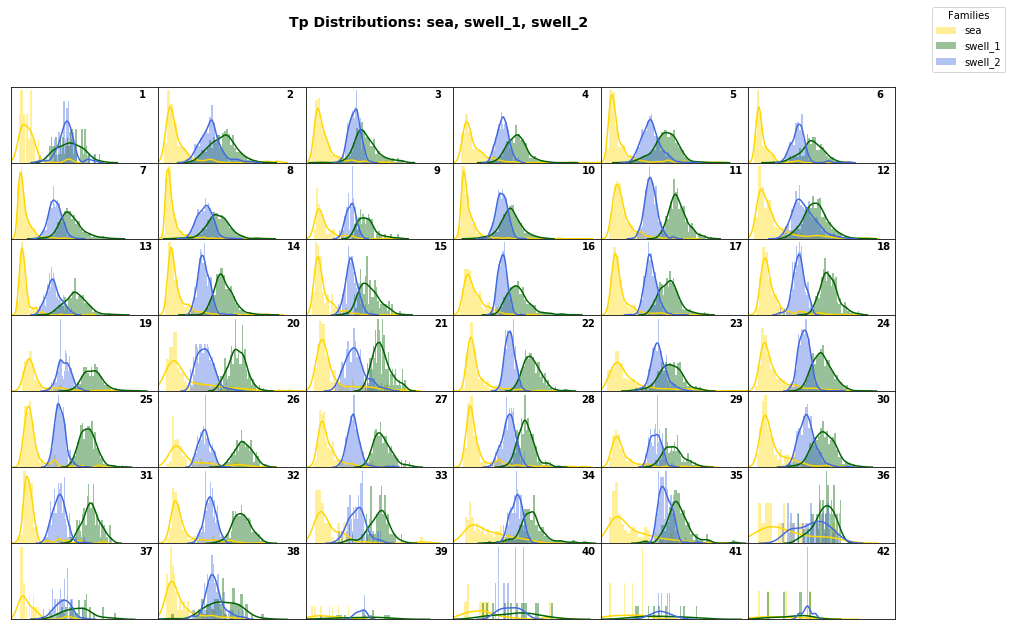

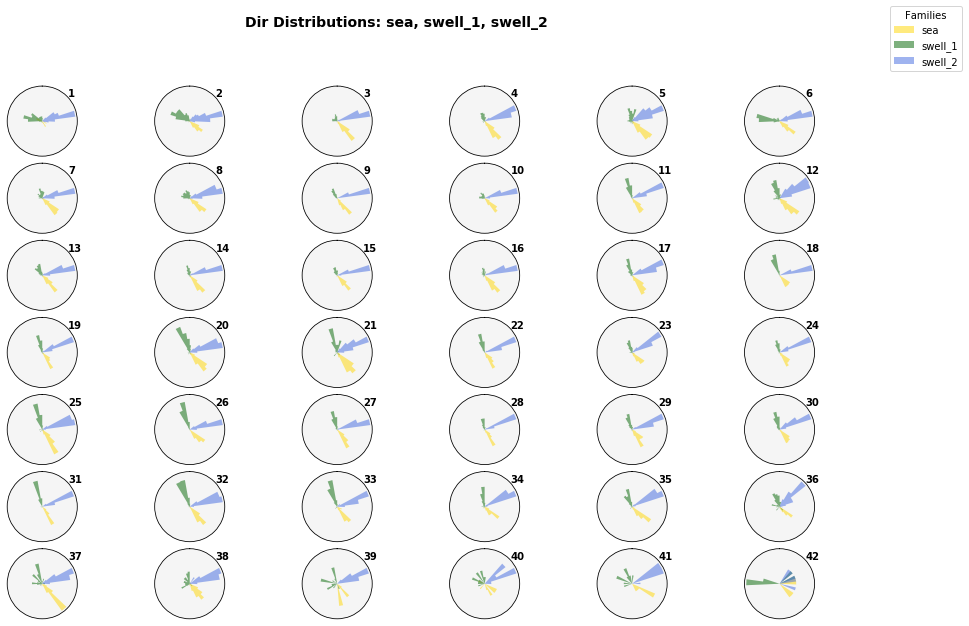

In [19]:
# Plot Waves Families by DWTs

# DWTs bmus
DWTs = pred.KMA
BMUS = xr.Dataset(
    {'bmus':(('time',), DWTs['sorted_bmus_storms'].values[:])},
    coords = {'time': DWTs.time.values[:]}
)
n_clusters = 42

# common dates
dates_common= xds_common_dates_daily([WAVES_d, DWTs])

# waves and bmus at common dates
WAVES_sel = WAVES_d.sel(time=dates_common)
bmus_sel = BMUS.sel(time=dates_common).bmus.values[:]

# Plot Waves Families by DWTs
Plot_Waves_DWTs(WAVES_sel, bmus_sel, n_clusters);
